In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.utils import shuffle
import plotly.graph_objects as go
import csv
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import string
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, LSTM
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/warwick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/warwick/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/warwick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
tesla_stock = pd.read_csv("TSLA.csv", encoding='latin1')
n_data = tesla_stock.shape[0]
feature_list = tesla_stock.columns
print("the number of stock data is:", n_data)
print("features are:", feature_list)
print("the number of features are:", len(feature_list))

times = tesla_stock['Date'][:].tolist()
times = [s.replace("-", "") for s in times]
tesla_stock.loc[:,("times")] = times
print(tesla_stock["times"].head(5))

#we only consider stock between 2012/11/15 and 2017/09/29, in accord with Elon Musk's tweet
tesla = tesla_stock[(tesla_stock.times >= "20121115") & (tesla_stock.times <= "20170929")]
print(tesla['times'].head(1))
print(tesla['times'].tail(1))
print("the number of trading days between 2012/11/15 and 2017/09/29 is:",tesla.shape[0])

the number of stock data is: 2416
features are: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
the number of features are: 7
0    20100629
1    20100630
2    20100701
3    20100702
4    20100706
Name: times, dtype: object
601    20121115
Name: times, dtype: object
1827    20170929
Name: times, dtype: object
the number of trading days between 2012/11/15 and 2017/09/29 is: 1227


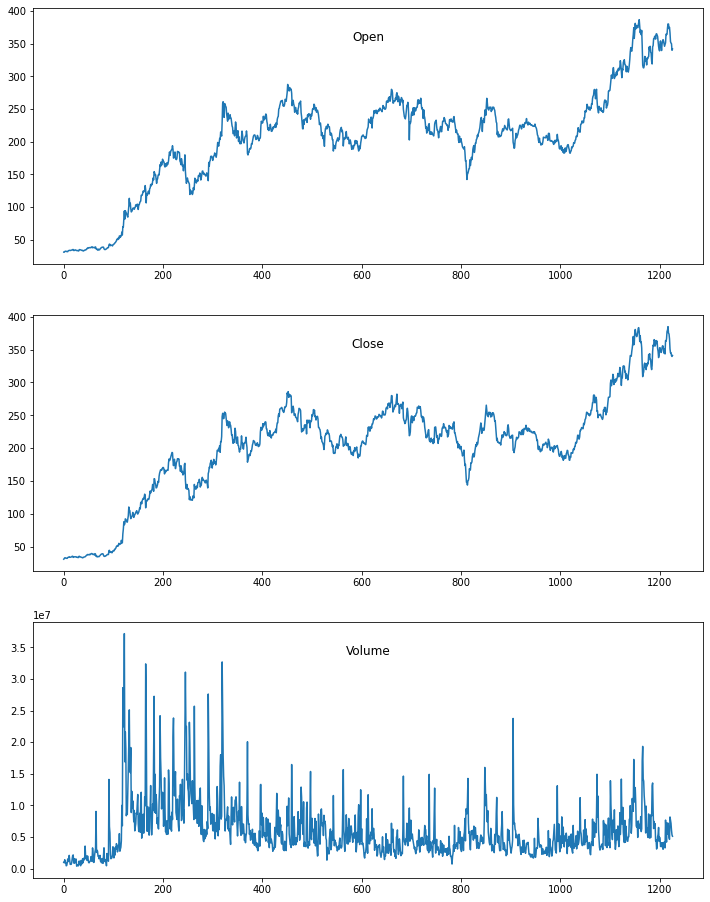

In [7]:
values = tesla.values
groups = [1,4,6]
plt.figure(figsize = (12,16))
i = 1
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(tesla.columns[group], y=0.85, loc='center')
    i += 1
plt.show()

In [10]:
#stupid baseline: a model that predict the price of tesla stock assume that the 
close_price_dataframe = tesla.filter(['Close'])
close_price = close_price_dataframe.values
#split data so that the first 70% data as training data and the rest 30% as validation dataset
training_data_len = int(np.ceil(len(close_price) * 0.7 ))
y_0 = close_price[0]
y_end = close_price[training_data_len-1]

#find a & b in ax+b = y
a = (y_end-y_0)/(training_data_len)
b = y_0
print("start stock price is:", y_0)
print("end stock price is:", y_end)
print(a,b)

start stock price is: [30.82]
end stock price is: [254.509995]
[0.26040744] [30.82]


In [14]:
#Create the data sets x_test and y_test
x_test = [i for i in range(training_data_len,len(close_price))]
y_test = close_price[training_data_len:, :]
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Get the models predicted price values 
predictions = [a*i+b for i in x_test]

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("the root mean squared error of LSTM:", rmse)

valid = close_price_dataframe[training_data_len:]
print("length of validation set:", valid.shape[0])
valid['Predictions'] = predictions

the root mean squared error of LSTM: 56.750464471207614
length of validation set: 368


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


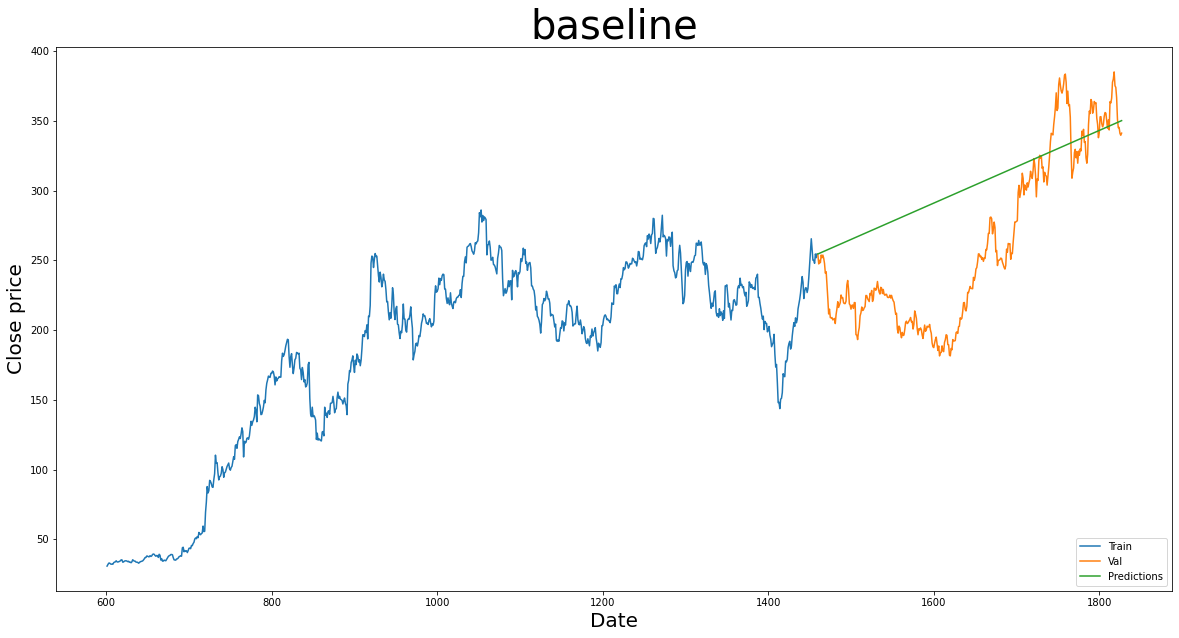

the root mean squared error of baseline 56.750464471207614


In [19]:
# Plot the data
train = close_price_dataframe[:training_data_len]
valid = close_price_dataframe[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(20,10))
plt.title('baseline',fontsize = 40)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close price', fontsize=20)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("the root mean squared error of baseline", rmse)

In [18]:
#the maximum amount of money that one can is purchase the stock at the begining and sell at the very end
max_gain = close_price[-1] - close_price[training_data_len]
print(max_gain, max_gain/close_price[training_data_len] * 100.0,"%")

[87.220001] [34.35481301] %
